In [1]:
import numpy as np 
import pandas as pd
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from scipy import special
from tqdm import tqdm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA



warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)

In [2]:
X_train = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/X_train_corr.csv')
y_train = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/y_train_large.csv').squeeze()
X_test = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/X_test_corr.csv')
y_test = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/y_test_large.csv').squeeze()

In [3]:
X_train.head()

,age,bmi,elective_surgery,gender,height,icu_id,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,icu_id_counts,age_counts,nan_counts,sq_age,sq_bmi,bmi_age,weight_age,comorbidity_score,diabete_risk,gcs_sum,apache_2_diagnosis_type,bmi_type,height_type,weight_type,age_type,gcs_sum_type,apache_3j_diagnosis_split1,apache_2_diagnosis_split1,profile,diff_bmi,bilirubin_d1_h1_max_eq,bilirubin_d1_h1_min_eq,bilirubin_h1_value_range,bilirubin_h1_zero_range,bilirubin_h1_mean,bilirubin_h1_std,bilirubin_h1_max_apache_3j_diagnosis_mean,bilirubin_h1_max_apache_3j_diagnosis_diff,bilirubin_h1_max_apache_3j_diagnosis_std,bilirubin_h1_max_apache_3j_diagnosis_norm_std,bilirubin_h1_max_apache_3j_diagnosis_rank,bilirubin_h1_max_apache_3j_diagnosis_count,bilirubin_h1_max_apache_3j_diagnosis_norm_rank,bilirubin_h1_max_apache_3j_diagnosis_skew,bilirubin_h1_min_apache_3j_diagnosis_mean,bilirubin_h1_min_apache_3j_diagnosis_diff,bilirubin_h1_min_apache_3j_diagnosis_std,bilirubin_h1_min_apache_3j_diagnosis_norm_std,bilirubin_h1_min_apache_3j_diagnosis_rank,bilirubin_h1_min_apache_3j_diagnosis_norm_rank,bilirubin_h1_min_apache_3j_diagnosis_skew,bilirubin_h1_max_profile_mean,bilirubin_h1_max_profile_diff,bilirubin_h1_max_profile_std,bilirubin_h1_max_profile_norm_std,bilirubin_h1_max_profile_rank,bilirubin_h1_max_profile_count,bilirubin_h1_max_profile_norm_ran

In [4]:
def evaluate_lightgbm(X_train, y_train, X_test, y_test):
    """
    Returns:
    - model (lgb.LGBMClassifier): Trained LightGBM model.
    - roc_auc (float): ROC-AUC score on the test set.
    - report (str): Classification report with precision, recall, and F1-score up to 4 decimals.
    """
    # Initialize the LightGBM classifier with default parameters
    model = lgb.LGBMClassifier(
        random_state=69,        # For reproducibility
        n_jobs=-1,
        force_col_wise=True              # Utilize all available cores
    )
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Predict probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Predict class labels
    y_pred = model.predict(X_test)
    
    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Generate classification report with 4 decimal places
    report = classification_report(y_test, y_pred, digits=4)
    
    # Print the evaluation metrics
    print(f"ROC-AUC: {roc_auc:.8f}")
    print("Classification Report:\n", report)
    
    return model, roc_auc, report

In [5]:
model, auc, report = evaluate_lightgbm(X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 850113
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 3698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
ROC-AUC: 0.87206368
Classification Report:
               precision    recall  f1-score   support

         0.0     0.8718    0.9385    0.9039     30574
         1.0     0.6934    0.5020    0.5824      8474

    accuracy                         0.8438     39048
   macro avg     0.7826    0.7202    0.7431     39048
weighted avg     0.8331    0.8438    0.8341     39048



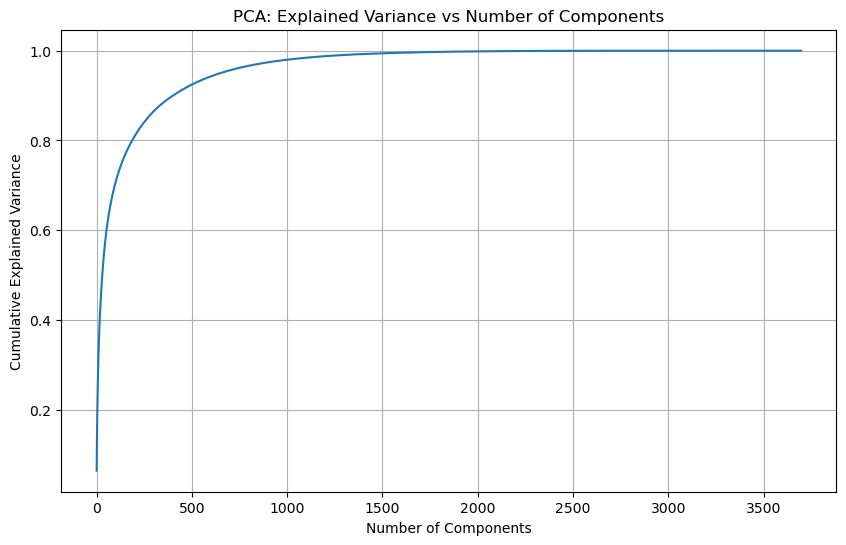

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA
pca = PCA().fit(X_train)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

In [7]:
pca = PCA(n_components=1000)

# Fit PCA on the training data
X_train_pca = pca.fit_transform(X_train)

# Transform the test data
X_test_pca = pca.transform(X_test)

print(f"Shape of reduced training set: {X_train_pca.shape}")
print(f"Shape of reduced test set: {X_test_pca.shape}")

Shape of reduced training set: (91109, 1000)
Shape of reduced test set: (39048, 1000)


In [8]:
model, auc, report = evaluate_lightgbm(X_train_pca, y_train, X_test_pca, y_test)

[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 255000
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
ROC-AUC: 0.82289615
Classification Report:
               precision    recall  f1-score   support

         0.0     0.8258    0.9653    0.8901     30574
         1.0     0.6797    0.2654    0.3817      8474

    accuracy                         0.8134     39048
   macro avg     0.7527    0.6154    0.6359     39048
weighted avg     0.7941    0.8134    0.7798     39048



[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 255000
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
AUC-ROC with top 100 features: 0.8226
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

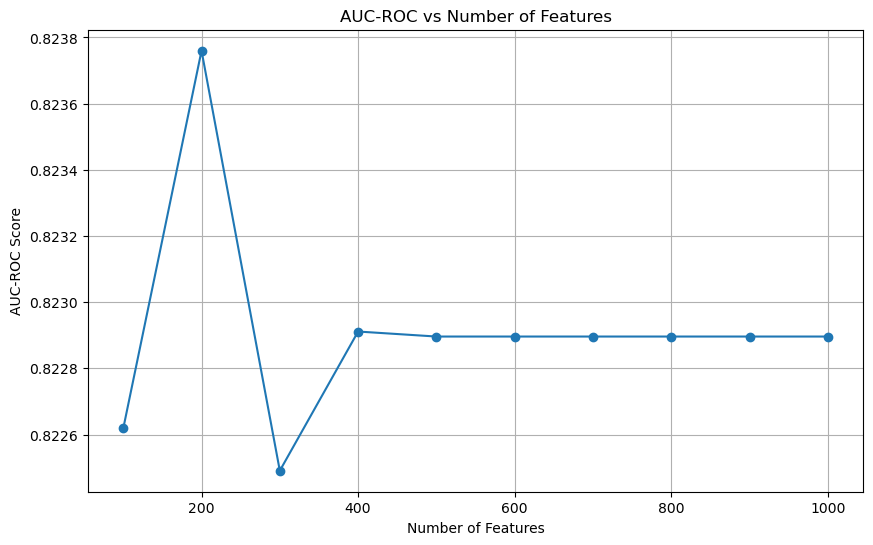

In [9]:
lgb_model = lgb.LGBMClassifier(
        random_state=69,        # For reproducibility
        n_jobs=-1,
        force_col_wise=True              # Utilize all available cores
    )


lgb_model.fit(X_train_pca, y_train)

# Step 2: Get feature importance and sort them
importance = lgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': range(X_train_pca.shape[1]),  # PCA components are numbered 0 to n_components
    'Importance': importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 3: Define feature subset sizes to evaluate (e.g., 100, 200, 300, ...)
feature_sizes = [100, 200, 300, 400, 500,600,700,800,900,1000]

# Store AUC-ROC values for plotting
auc_roc_values = []

# Step 4: Train LightGBM for different numbers of top features
for size in feature_sizes:
    # Select the top 'size' features based on importance
    top_features = feature_importance_df['Feature'].head(size).tolist()
    
    # Reduce the PCA-transformed training and test sets to the top features
    X_train_top = X_train_pca[:, top_features]
    X_test_top = X_test_pca[:, top_features]
    
    # Train LightGBM on the reduced feature set
    lgb_model_reduced = lgb.LGBMClassifier(random_state=42)
    lgb_model_reduced.fit(X_train_top, y_train)
    
    # Make predictions and calculate AUC-ROC
    y_pred_proba = lgb_model_reduced.predict_proba(X_test_top)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_roc_values.append(auc_roc)
    
    print(f"AUC-ROC with top {size} features: {auc_roc:.4f}")

# Step 5: Plot AUC-ROC values vs number of features
plt.figure(figsize=(10, 6))
plt.plot(feature_sizes, auc_roc_values, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('AUC-ROC Score')
plt.title('AUC-ROC vs Number of Features')
plt.grid(True)
plt.show()